# Проект: оценка результатов А/В теста

## Введение  

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

**Цель:** провести оценку результатов A/B-теста:
- оценить корректность проведения теста
- проанализировать результаты теста после внедрения улучшенной рекомендательной системы
    
Исследование проводится в 5 этапов:

1. Обзор данных  
2. Предобработка данных  
3. Оценка корректности проведения теста    
4. Исследовательский анализ данных  
5. Оценка результатов А/В теста   
6. Итоги исследования  

## Обзор данных  

Ознакомимся с входными данными.

In [1]:
# импортируем библиотеки

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from scipy import stats as st
import math as mth

In [2]:
# игнорируем предупреждения

import warnings
warnings.filterwarnings('ignore') 

# снимем ограничения на вывод строк и столбцов

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
#прочитаем файлы с данными и сохраним их в переменные

events = pd.read_csv('/datasets/final_ab_events.csv')
pm_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
participants = pd.read_csv('/datasets/final_ab_participants.csv')

# выведем на экран первые 5 строк таблиц

display(events.head()) 
display(pm_events.head()) 
display(new_users.head())
display(participants.head()) 

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [4]:
# получим общую информацию о таблицах

display(events.info()) 
display(pm_events.info())
display(new_users.info())
display(participants.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

**В наличии следующие данные:**  

`pm_events` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`new_users` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`events` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`participants` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя. 


### Выводы:  

В нашем распоряжении 4 таблицы с данными об маркетинговых событиях на 2020 год, о новых пользователях зарегистрировавшиеся с 7 по 21 декабря 2020 года, об их действиях с 7 декабря 2020 по 4 января 2021 года, а также таблица участников теста "recommender_system_test".    

В таблице events есть пропуски значений в дополнительных данных о событии, скорее всего это отсутствие данных, и пропуски не случайные. Такие пропуски заполнять не будем.

Типы даннах столбцов с датами заменим на тип данных date.  

## Предобработка данных  

### Заменим тип данных столбцов с датами

In [5]:
# заменим тип данных на datetime64

events['event_dt'] = pd.to_datetime(events['event_dt'])
pm_events['start_dt'] = pd.to_datetime(pm_events['start_dt'])
pm_events['finish_dt'] = pd.to_datetime(pm_events['finish_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

### Добавим недостающие данные

In [6]:
# добавим столбец в таблице events только с датой

events['date'] = events['event_dt'].dt.date.astype('datetime64')
events.head()

,user_id,event_dt,event_name,details,date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07


### Проверим наличие дубликатов

In [7]:
# найдем сумму явных дубликатов в таблицах

display(events.duplicated().sum())
display(pm_events.duplicated().sum())
display(new_users.duplicated().sum())
display(participants.duplicated().sum())

0

0

0

0

### Рассмотрим пропуски в столбце details таблицы events

In [8]:
# найдем пропуски в столбце details и сохраним их в переменную

details = events[events['details'].isna()]

# найдем долю каждого события в общем количестве пропусков
 
details['event_name'].value_counts(normalize=True)

login           0.502022
product_page    0.332549
product_cart    0.165429
Name: event_name, dtype: float64

Пропусков в стоимости покупок нет, остальные - это отсутствие дополнительных сведений. Заполнять нет необходимости.

### Проверим корректность значений в таблицах

In [9]:
#выведет уникальные значения

print('Названия маркетингового события:', pm_events['name'].unique())
print('Регионы, в которых будет проводиться рекламная кампания', pm_events['regions'].unique())
print('Устройство, с которого происходила регистрация', new_users['device'].unique())
print('Регион пользователя', new_users['region'].unique())
print('Тип события', events['event_name'].unique())
print('Название теста', participants['ab_test'].unique())
print('Группа пользователя', participants['group'].unique())

Названия маркетингового события: ['Christmas&New Year Promo' "St. Valentine's Day Giveaway"
 "St. Patric's Day Promo" 'Easter Promo' '4th of July Promo'
 'Black Friday Ads Campaign' 'Chinese New Year Promo'
 'Labor day (May 1st) Ads Campaign' "International Women's Day Promo"
 'Victory Day CIS (May 9th) Event' 'CIS New Year Gift Lottery'
 'Dragon Boat Festival Giveaway' "Single's Day Gift Promo"
 'Chinese Moon Festival']
Регионы, в которых будет проводиться рекламная кампания ['EU, N.America' 'EU, CIS, APAC, N.America' 'N.America' 'APAC'
 'EU, CIS, APAC' 'CIS']
Устройство, с которого происходила регистрация ['PC' 'Android' 'iPhone' 'Mac']
Регион пользователя ['EU' 'N.America' 'APAC' 'CIS']
Тип события ['purchase' 'product_cart' 'product_page' 'login']
Название теста ['recommender_system_test' 'interface_eu_test']
Группа пользователя ['A' 'B']


В таблицу с участниками теста попал еще один тест, уберем строки с участниками другого теста

In [10]:
# перезапишем таблицу, убрав из нее ненужные данные 

participants_new = participants.loc[participants.loc[:, 'ab_test'] != 'interface_eu_test']
participants_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6701 entries, 0 to 6700
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  6701 non-null   object
 1   group    6701 non-null   object
 2   ab_test  6701 non-null   object
dtypes: object(3)
memory usage: 209.4+ KB


Кол-во участников теста отличается от ожидаемого на 700 человек.

### Вывод:  

Заменили типы данных в столбцах с датами на date.  

Добавили столбец к таблице events только с датой.  

Дубликаты отсутствуют.  

Пропуски не случайны, заполнять нет необходимости, это не помешает исследованию.

Нашли в таблице с участниками теста, пользователей, участвующих в конкурирующем тесте. Убрали эти данные из таблицы.

## Оценка корректности проведения теста

### Найдем максимальную и минимальную дату регистрации новых пользователей

In [11]:
display(new_users['first_date'].min())
display(new_users['first_date'].max())

Timestamp('2020-12-07 00:00:00')

Timestamp('2020-12-23 00:00:00')

Данные не совпадают с технческим заданием, последние зарегистрировавшиеся пользоватили были 23 декабря 2020, а не 21 декабря.  

### Проанализируем даты событий  

Посмотрим на максимальную и минимальную дату событий

In [12]:
display(events['date'].min())
display(events['date'].max())

Timestamp('2020-12-07 00:00:00')

Timestamp('2020-12-30 00:00:00')

Действия новых пользователей заканчиваются 30 декабря 2020 года.  
Посмотрим даты новогодней маркетинговой компании.

In [13]:
# выведем строку с новогодней маркетинговой компанией

pm_events.loc[pm_events.loc[:, 'name'] == 'Christmas&New Year Promo']

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Нужно убрать из теста данные с 25 декабря по 30 декабря, так как на действия пользователей могла повлиять маркетинговая компания.  



In [14]:
# перезапишем таблицу, убрав из нее ненужные данные 

events_new = events.loc[events.loc[:, 'date'] < '2020-12-25']

### Посмотрим, есть ли пользователи, участвующие в двух группах теста одновременно

In [15]:
# выведем кол-во строк в таблице и ко-во уникальных id

display(participants_new.shape[0])
display(len(participants_new['user_id'].unique()))

6701

6701

Кол-во строк в таблице и кол-во уникальных пользователей одинаково, следовательно id не повторяются, и нет пользователей попавших одновременно в группу А и В.  

### Посмотрим равномерность распределения пользователей по группам теста

In [16]:
# сгруппируем по группам теста и посчитаем пользователей

participants_new.groupby('group')['user_id'].count()

group
A    3824
B    2877
Name: user_id, dtype: int64

Пользователи распределены достаточно равномерно.

### Соединим таблицу со всеми зарегистрировавшимися пользователями с участниками теста

In [17]:
# соединим таблицу participants_new с new_users_new

participants_users = participants_new.merge(new_users, on='user_id', how='left')
display(participants_users.head())
display(participants_users.info())

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6701 entries, 0 to 6700
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     6701 non-null   object        
 1   group       6701 non-null   object        
 2   ab_test     6701 non-null   object        
 3   first_date  6701 non-null   datetime64[ns]
 4   region      6701 non-null   object        
 5   device      6701 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 366.5+ KB


None

Проверим, что 15% новых пользователей из региона EU

In [18]:
# найдем процент от общего кол-ва

participants_users.groupby('region').size()/ len(participants_users)

region
APAC         0.010745
CIS          0.008208
EU           0.947769
N.America    0.033279
dtype: float64

Из региона EU 94% пользователей.

In [44]:
# посчитаем долю участников теста от всех новых пользователей из региона EU

participants_users.query('region == "EU"')['region'].count()/new_users.query('region == "EU"')['region'].count() * 100

13.725956343202938

Доля участников из региона EU составляе 14%.

### Определим пользователей, которых можно использовать для оценки А/В теста   

Если мы исследуем данные за 14 дней после регистрации пользователя, то в исследуемую группу могут попаcть только пользователи, зарегистрировавшиеся не позже 10 декабря 2020 года.  

Посчитаем новых пользователей, зарегистрировавшихся не позже 10 декабря.  

In [20]:
# посмотрим на таблицу только с нужными нам данными

participants_users.loc[participants_users.loc[:, 'first_date'] < '2020-12-10'].count()

user_id       1267
group         1267
ab_test       1267
first_date    1267
region        1267
device        1267
dtype: int64

Получилось, что из всего кол-ва участвующих в тесте пользователей, по прошествии 14 дней для исследования можно использовать только 1267 человек.

### Вывод:  

Оценили данные, представленные в таблицах. Обнаружили пользователей, пересекающихся с конкурирующим тестом, удалили данные по конкурирующему тесту.   

Убрали из таблицы событий действия, совершенные после 25 декабря. Так как с 25 декабря по 3 января проводилась новогодняя маркетинговая компания, которая могла повлиять на результаты теста.  

Пользователи распределены по группам достаточно равномерно. Участников попавших в обе группы одновременно нет.  

Определили, что 94% участников теста из региона EU. А доля участников из региона EU от всего кол-ва новых пользователей изи EU составляет 14%. 

Установили, что пользователей, у которых прошло 14 дней с момента регистрации всего 1267 человек, это зарегистрировавшиеся с 7 по 10 декабря 2020 года.

## Исследовательский анализ данных

### Соединим таблицу с участниками А/В теста и событиями

In [21]:
# объединим данные из двух таблиц

participants_users_events = participants_users.merge(events_new, on='user_id', how='left')
display(participants_users_events.head())
display(participants_users_events.info())

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,date
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,NaN,2020-12-07
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,NaN,2020-12-20


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24396 entries, 0 to 24395
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     24396 non-null  object        
 1   group       24396 non-null  object        
 2   ab_test     24396 non-null  object        
 3   first_date  24396 non-null  datetime64[ns]
 4   region      24396 non-null  object        
 5   device      24396 non-null  object        
 6   event_dt    21370 non-null  datetime64[ns]
 7   event_name  21370 non-null  object        
 8   details     2859 non-null   float64       
 9   date        21370 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), object(6)
memory usage: 2.0+ MB


None

По кол-ву пропусков видно, что в таблице есть участники, которые не совершили ни одного действия. Скорее всего, события, которые совершили эти пользователи не были записаны.

Удаление строк с участниками без событий повлияет на результаты исследования, но на данном этапе мы не можем восстановить эти данные.

### Разделим получившуюся таблицу на две по группам теста

In [22]:
# удалим строки без событий

participants_users_events.dropna(subset=['event_name'], inplace=True)

# создадим две таблица по группам А и В

participants_users_events_a = participants_users_events.query('group == "A"')
participants_users_events_b = participants_users_events.query('group == "B"')

### Посмотрим на данные по событиям в группах  

- для группы А

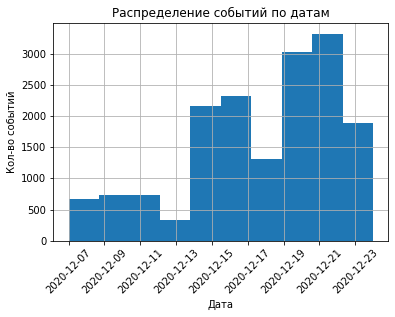

In [23]:
# построим гистограмму по столбцу date

participants_users_events_a['date'].hist()
plt.xticks(rotation=45)
plt.title('Распределение событий по датам')
plt.xlabel('Дата')
plt.ylabel('Кол-во событий');

- для группы В

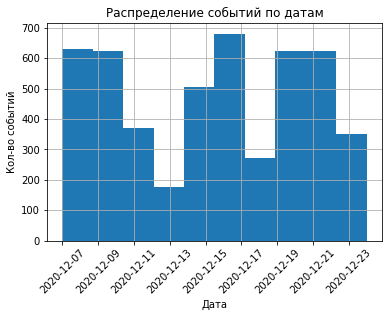

In [24]:
# построим гистограмму по столбцу date

participants_users_events_b['date'].hist()
plt.xticks(rotation=45)
plt.title('Распределение событий по датам')
plt.xlabel('Дата')
plt.ylabel('Кол-во событий');

Данных достаточно для всех дат, будем использовать данные за весь период.  
На обоих графиках наблюдаются провалы 13 и 17 декабря, в эти дни было совершено наименьшее кол-во действий, возможно, это связано с работой сайта.

### Узнаем сколько всего событий и пользователей по группам, а также сколько в среднем событий приходится на пользователя в каждой группе  

- для группы А

In [25]:
# выведем кол-во уникальных значений для столбца user_id и общее кол-во событий

display(participants_users_events_a['user_id'].nunique())
display(participants_users_events_a['event_name'].count())

2747

16513

In [26]:
# рассчитаем медианное и среднее значение событий для одного пользователя

display(participants_users_events_a.groupby('user_id')['event_name'].count().median())
display(participants_users_events_a.groupby('user_id')['event_name'].count().mean())

6.0

6.011285038223517

- для группы В

In [27]:
# выведем кол-во уникальных значений для столбца user_id и общее кол-во событий

display(participants_users_events_b['user_id'].nunique())
display(participants_users_events_b['event_name'].count())

928

4857

In [28]:
# рассчитаем медианное и среднее значение событий для одного пользователя

display(participants_users_events_b.groupby('user_id')['event_name'].count().median())
display(participants_users_events_b.groupby('user_id')['event_name'].count().mean())

4.0

5.233836206896552

Кол-во уникальных пользователей и событий в каждой группе достаточно сильно отличаются: в группе В почти в три раза меньше участников.   
Среднее значение событий для каждого пользователя в группе А близко к медианному и равно 6. А для группы В в среднем 5 событий.

### Проанализируем события в группах  и посчитаем, какая доля пользователей проходит на следующий шаг воронки

- **для группы А**

In [29]:
count_id_a = participants_users_events_a['user_id'].nunique()

# создадим сводную, в которую запишем кол-во каждого события и кол-во уникальных пользователей его совершивших
data_pivot_a = participants_users_events_a.pivot_table(index='event_name', values='user_id', aggfunc=['count', 'nunique']).reset_index()

# добавим столбец с процентом пользователей, совершивших определенное действие относительно общего кол-ва уникальных пользователей
data_pivot_a['percent'] = data_pivot_a[('nunique', 'user_id')]/count_id_a*100

# поменяем местами строки
data_pivot_a = data_pivot_a.reindex([0,2,1,3]).round(2).reset_index(drop=True)
data_pivot_a.round()

,event_name,count,nunique,percent
,,user_id,user_id,
0,login,7345,2747,100.0
1,product_page,4716,1780,65.0
2,product_cart,2204,824,30.0
3,purchase,2248,872,32.0


Событий "покупка" больше, чем событий "просмотр корзины". Либо можно оплатить не заходя в корзину, либо это ошибка данных и были потеряны пользователи, просматривавшие корзину.

In [30]:
# создадим список из столбца nunique user_id
nunique_id_a = data_pivot_a[('nunique', 'user_id')].tolist()

# создадим функцию, которая посчитает процент по каждому шагу относительно предыдущего действия
conversion = [100]
for i in range(len(nunique_id_a)):
    conversion.append(nunique_id_a[i]/nunique_id_a[i-1]*100)
    
conversion.pop(1)

#добавим столбцы с процентами пользователей, которые переходят на следующий шаг
data_pivot_a['percent_2'] = conversion #от предыдущего шага
data_pivot_a.round()

,event_name,count,nunique,percent,percent_2
,,user_id,user_id,,
0,login,7345,2747,100.0,100.0
1,product_page,4716,1780,65.0,65.0
2,product_cart,2204,824,30.0,46.0
3,purchase,2248,872,32.0,106.0


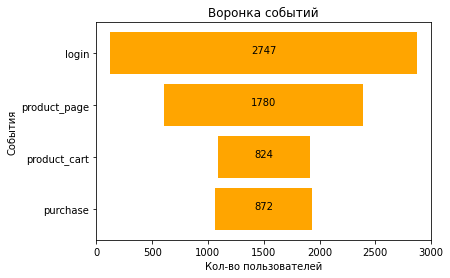

In [31]:
# создадим список из столбца event_name
event_name = data_pivot_a[('event_name','')].tolist()

# создадим график воронки событий
y = list(reversed(event_name))
x = list(reversed(nunique_id_a))
x_max = 3000
x_min = 0
for idx, val in enumerate(x):
    left = (x_max - val)/2
    plt.barh(y[idx], x[idx], left = left, color='orange')
    plt.text(1500, y[idx], x[idx], ha='center')

plt.xlim(x_min, x_max)
plt.title('Воронка событий')
plt.xlabel('Кол-во пользователей')
plt.ylabel('События');

Из всех зашедших на сайт 65% перешли на карточку товара и только 46% перешли в корзину. По этим данным получается, что все 100% оплатили товар после перехода в корзину.

- **для групы В**

In [32]:
count_id_b = participants_users_events_b['user_id'].nunique()

# создадим исводную, в которую запишем кол-во каждого события и кол-во уникальных пользователей его совершивших
data_pivot_b = participants_users_events_b.pivot_table(index='event_name', values='user_id', aggfunc=['count', 'nunique']).reset_index()

# добавим столбец с процентом пользователей, совершивших определенное действие относительно общего кол-ва уникальных пользователей
data_pivot_b['percent'] = data_pivot_b[('nunique', 'user_id')]/count_id_b*100

# поменяем местами строки
data_pivot_b = data_pivot_b.reindex([0,2,1,3]).round(2).reset_index(drop=True)
data_pivot_b.round()

,event_name,count,nunique,percent
,,user_id,user_id,
0,login,2348,927,100.0
1,product_page,1262,523,56.0
2,product_cart,636,255,27.0
3,purchase,611,256,28.0


In [33]:
# создадим список из столбца nunique user_id
nunique_id_b = data_pivot_b[('nunique', 'user_id')].tolist()

# создадим функцию, которая посчитает процент по каждому шагу относительно предыдущего действия
conversion_1 = [100]
for i in range(len(nunique_id_b)):
    conversion_1.append(nunique_id_b[i]/nunique_id_b[i-1]*100)
    
conversion_1.pop(1)

#добавим столбцы с процентами пользователей, которые переходят на следующий шаг
data_pivot_b['percent_2'] = conversion_1 #от предыдущего шага
data_pivot_b.round()

,event_name,count,nunique,percent,percent_2
,,user_id,user_id,,
0,login,2348,927,100.0,100.0
1,product_page,1262,523,56.0,56.0
2,product_cart,636,255,27.0,49.0
3,purchase,611,256,28.0,100.0


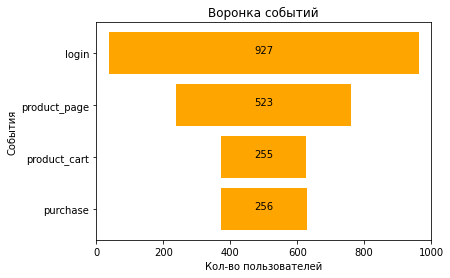

In [34]:
# создадим список из столбца event_name
event_name = data_pivot_b[('event_name','')].tolist()

# создадим график воронки событий
y = list(reversed(event_name))
x = list(reversed(nunique_id_b))
x_max = 1000
x_min = 0
for idx, val in enumerate(x):
    left = (x_max - val)/2
    plt.barh(y[idx], x[idx], left = left, color='orange')
    plt.text(500, y[idx], x[idx], ha='center')

plt.xlim(x_min, x_max)
plt.title('Воронка событий')
plt.xlabel('Кол-во пользователей')
plt.ylabel('События');

После внедрения улучшенной рекомендательной системы из всех зашедших на сайт только 56% перешли на карточку товара и 49% прешли в корзину, что всего на 2% отличается от группы А. Так же 100% оплатили товар после прехода в корзину.  

### Вывод:  

Проанализировав данные, стало понятно, что данные в таблице events были записаны некорректно. Почти у половины участников нет никаких данных о совершенных ими действиях.  

Событий "покупка" больше, чем событий "просмотр корзины". Либо можно оплатить не заходя в корзину, либо это ошибка данных и были потеряны данные о просматривавших корзину.   

По имеющимся данным установили, что процент перешедших на карточку товара для группы В изменился и понизился до 56%. Кол-во тех, кто перешел в корзину в групе В увеличилось на 3%. В обеих группах 100% оплата после перехода в корзину.  

## Оценка результатов А/В теста

### Проверим статистическую разницу долей z-критерием  

**Нулевые гипотезы:**  
- доли перешедших на карточку товара от общего числа пользователей для груп А и В равны
- доли перешедших в корзину от общего числа пользователей для групп А и В равны  
- доли оплативших товар от общего числа пользователей для групп А и В равны  

**Альтернативные гипотезы:**  
- доли перешедших на карточку товара от общего числа пользователей для груп А и В не равны
- доли перешедших в корзину от общего числа пользователей для групп А и В не равны  
- доли оплативших товар от общего числа пользователей для групп А и В не равны  

Уровень статистической значимости зададим в 1%.

In [35]:
# напишем функицию для z_test

def z_test (list_1, list_2, list_3, list_4):
    
    alpha = 0.01
    
    successes = np.array([list_1, list_2])
    trials = np.array([list_3, list_4])
    
    # доля пользователей от ощего кол-ва в первом тесте:
    p1 = successes[0]/trials[0]
    
    # доля пользователей от ощего кол-ва во втором тесте:
    p2 = successes[1]/trials[1]
    
    # доля пользователей в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # посчитаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # зададим стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [36]:
# создадим список с общим кол-вом пользователей в каждой группе
list_count = participants_users_events.groupby('group')['user_id'].nunique().tolist()

# создадим из столбцов списки
a_list = nunique_id_a
b_list = nunique_id_b

# проведем z-test для групп А и В
print('Для перехода на карточку товара:')
z_test(a_list[1], b_list[1], list_count[0], list_count[1])
print()

print('Для перехода в корзину:')
z_test(a_list[2], b_list[2], list_count[0], list_count[1])
print()

print('Для оплаты:')
z_test(a_list[3], b_list[3], list_count[0], list_count[1])
print()


Для перехода на карточку товара:
p-значение:  4.310980554755872e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница

Для перехода в корзину:
p-значение:  0.14534814557238196
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для оплаты:
p-значение:  0.017592402663314743
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Для первой гипотезы p-value ниже 1%, следовательно отвергаем нулевую гипотезу и принимаем альтернативную: доли перешедших на карточку товара от общего числа пользователей для груп А и В не равны. 

Для остальных гипотез значение p-value выше 1%, следовательно гипотезы подтверждены: доли пользователей в разных группах равны на всех этапах покупки.

Из результатов теста можно сделать вывод, что изменения повлияли только на пользователей перешедших на карточку товара.

## Итоги исследования

Прежде, чем исследовать данные, мы ознакомились с ними, заменили тип данных в столбцах с датами, добавили недостающие данные, проверили наличие пропусков и дубликатов.

Из технического задания известно, что А/В тест проводился с 7 декабря 2020 года по 4 января 2021 года.  

Исследуя данные, определили что:  

- в таблице есть данные по конкурирующему тесту, которые нужно убрать;
- пользователей, с момента регистрации в системе которых не прошло 14 дней, нельзя использовать для оценки теста;
- период, в который проводилась новогодняя маркетинговая компания, нужно исключить из таблицы.

Перед тем как оценить результаты теста посмотрели равномерность распределения пользователей по группам: в группу В попало в три раза меньше участников, чем в группу А. Нужно было провести А/А тест, чтобы убедиться, что распределение происходит равномерно.  

События в эксперименте представляют собой последовательность действий пользователя при покупке товара.  
Пользователь регистрируется ---> Нажимает на карточку товара ---> Добавляет товар в корзину ---> Оплачивает товар  

Для обработки результатов А/В теста было выдвинуто 3 гипотезы о равенстве долей пользователей на этапах событийной воронки от общего кол-ва пользователей.

Доли пользователей в группе В равны долям пользователей в группе А отличаются на этапе "перехода на карточку товара", на остальных этапах доли равны, следовательно изменения, связанные с внедрением улучшенной рекомендательной системы, повлияли только на действия пользователей, переходщих на карточку товара после регистрации.  

По воронке событий видно, что процент перешедших на карточку товара в группе В уменьшился на 9%. Поэтому можно сказать, что ожидаемый эффект от изменений, связанных с внедрением улучшенной рекомендательной системы не оправдался.

P.S. Прежде, чем приступать к А/В тестированию, необходимо было удостоверится, что действия пользователей на сайте записываются корректно. Было обнаружено, что у большого кол-ва пользователей, которых можно было использовать для исследования, отсутствовали данные об их действиях. В результате для оценки теста осталось слишком мало данных, на основе которых можно было бы сделать выводы.   
А также, тест не стоило проводить во время маркетинговой рекламной компании, так как это может исказить данные.  